# Итоговая работа

## Выполнил: Зюликов Олег Александрович

## Задание для итоговой работы

**Анализ данных о покупках** 

Нужно выполнить предварительную обработку данных, сделать разведочный анализ данных EDA, затем проверить гипотезу о данных, выполнить кластеризацию по товарам, определить важные признаки, построить рекомендательную систему. Метод для составления рекомендаций выбрать самостоятельно.

Файл с датасетом - dataset.csv

Датасет - информация о покупках клиентов:

**Дата** - время покупки

**Транзакция** - уникальный номер покупки

**Клиент** - уникальный номер клиента

**Товар** - уникальный номер товара

**Количество** - количество купленных товаров

**Сумма** - цена покупки этого товара

### 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math
from datetime import datetime
import datetime as dt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

%matplotlib inline

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid", {'axes.grid' : True})

### 2. Загрузка данных

In [2]:
data = pd.read_csv('dataset.csv', delimiter=';')
data

,Дата,Транзакция,Клиент,Товар,Количество,Сумма
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0
...,...,...,...,...,...,...
48298,06.07.2021 15:00,25398,11049,1211.0,1.0,20500.0
48299,06.07.2021 15:13,25399,11049,3034.0,1.0,21950.0
48300,06.07.2021 15:02,25412,11050,443.0,1.0,1490.0
48301,06.07.2021 15:02,25412,11050,2789.0,1.0,9450.0


### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [3]:
data.columns

Index(['Дата', 'Транзакция', 'Клиент', 'Товар', 'Количество', 'Сумма'], dtype='object')

In [4]:
data.columns = ['дата', 'транзакция', 'клиент', 'товар', 'количество', 'сумма']
data.head()

,дата,транзакция,клиент,товар,количество,сумма
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48303 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   дата        48303 non-null  object 
 1   транзакция  48303 non-null  int64  
 2   клиент      48303 non-null  int64  
 3   товар       48273 non-null  float64
 4   количество  48303 non-null  float64
 5   сумма       48303 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.0+ MB


In [6]:
data['количество'] = data['количество'].astype(int)
print(data.dtypes)

дата           object
транзакция      int64
клиент          int64
товар         float64
количество      int32
сумма         float64
dtype: object


In [7]:
data.isnull().sum()

дата           0
транзакция     0
клиент         0
товар         30
количество     0
сумма          0
dtype: int64

In [8]:
data = data.dropna()
data

,дата,транзакция,клиент,товар,количество,сумма
0,03.05.2020 21:43,954,1,2874.0,1,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1,2860.0
3,03.05.2020 21:15,951,2,2812.0,1,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1,840.0
...,...,...,...,...,...,...
48298,06.07.2021 15:00,25398,11049,1211.0,1,20500.0
48299,06.07.2021 15:13,25399,11049,3034.0,1,21950.0
48300,06.07.2021 15:02,25412,11050,443.0,1,1490.0
48301,06.07.2021 15:02,25412,11050,2789.0,1,9450.0


In [9]:
data.isnull().sum()

дата          0
транзакция    0
клиент        0
товар         0
количество    0
сумма         0
dtype: int64

In [10]:
data.duplicated().sum()

1127

In [11]:
data = data.drop_duplicates()
data

,дата,транзакция,клиент,товар,количество,сумма
0,03.05.2020 21:43,954,1,2874.0,1,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1,2860.0
3,03.05.2020 21:15,951,2,2812.0,1,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1,840.0
...,...,...,...,...,...,...
48298,06.07.2021 15:00,25398,11049,1211.0,1,20500.0
48299,06.07.2021 15:13,25399,11049,3034.0,1,21950.0
48300,06.07.2021 15:02,25412,11050,443.0,1,1490.0
48301,06.07.2021 15:02,25412,11050,2789.0,1,9450.0


In [12]:
data.duplicated().sum()

0

На данном этапе выполнили:
- изменение названий признаков,
- преобразование данных,
- выявление и удаление пропущенных значений признаков,
- выявление и удаление дублирующих строк.

В итоге получили датасет с 47146 записями.

### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

In [13]:
#Ваш код

#График распределения плотности 


#График зависимости даты от суммы продаж или количество проданных товаров

# Стобчатая диаграмма частоты покупок от количество часов

# Показать товары  максимальной выручкой за все время или популярные товары

#Создать дополнительные признаки 
#объем продаж и суммарное количество


In [14]:
data.describe()

,транзакция,клиент,товар,количество,сумма
count,47146.000000,47146.000000,47146.000000,47146.0,47146.000000
mean,13170.802974,4545.535867,3126.636745,1.0,10455.257645
std,7668.957751,3031.557668,1655.168978,0.0,12701.269894
min,1.000000,1.000000,1.000000,1.0,504.000000
25%,6373.250000,2000.000000,1822.000000,1.0,3810.000000
50%,13290.500000,3922.000000,3146.000000,1.0,6910.000000
75%,19749.000000,6903.000000,4803.000000,1.0,12750.000000
max,26512.000000,11050.000000,5523.000000,1.0,511500.000000


Построим график распределения плотности

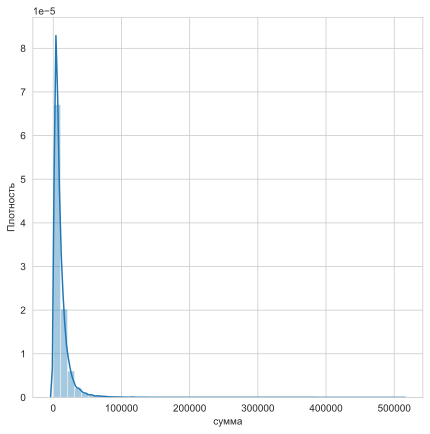

In [15]:
fig, axes = plt.subplots(1, sharey=True, figsize=(7,7))
sns.distplot(data['сумма'])
plt.ylabel('Плотность');

Поменяем тип данных признака `дата` и введем еще один признак - `дата_2`.

In [16]:
data['дата'] = pd.to_datetime(data['дата'])
data['дата_2'] = pd.to_datetime(data['дата']).dt.normalize()
data

,дата,транзакция,клиент,товар,количество,сумма,дата_2
0,2020-03-05 21:43:00,954,1,2874.0,1,8150.0,2020-03-05
1,2020-11-20 20:46:00,13796,1,3586.0,1,3930.0,2020-11-20
2,2020-08-12 16:28:00,14431,1,4942.0,1,2860.0,2020-08-12
3,2020-03-05 21:15:00,951,2,2812.0,1,4895.0,2020-03-05
4,2020-05-20 16:46:00,3352,2,5025.0,1,840.0,2020-05-20
...,...,...,...,...,...,...,...
48298,2021-06-07 15:00:00,25398,11049,1211.0,1,20500.0,2021-06-07
48299,2021-06-07 15:13:00,25399,11049,3034.0,1,21950.0,2021-06-07
48300,2021-06-07 15:02:00,25412,11050,443.0,1,1490.0,2021-06-07
48301,2021-06-07 15:02:00,25412,11050,2789.0,1,9450.0,2021-06-07


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47146 entries, 0 to 48302
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   дата        47146 non-null  datetime64[ns]
 1   транзакция  47146 non-null  int64         
 2   клиент      47146 non-null  int64         
 3   товар       47146 non-null  float64       
 4   количество  47146 non-null  int32         
 5   сумма       47146 non-null  float64       
 6   дата_2      47146 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1), int64(2)
memory usage: 2.7 MB


Построим график зависимости даты от суммы продаж.

In [18]:
data_group = data[['сумма', 'дата_2']].groupby('дата_2').sum().reset_index()
data_group

,дата_2,сумма
0,2020-01-05,2999052.96
1,2020-01-06,184500.00
2,2020-01-07,430400.00
3,2020-01-08,208770.00
4,2020-01-09,926915.00
...,...,...
461,2021-12-03,234379.50
462,2021-12-04,517908.50
463,2021-12-05,1578498.87
464,2021-12-06,2131892.95


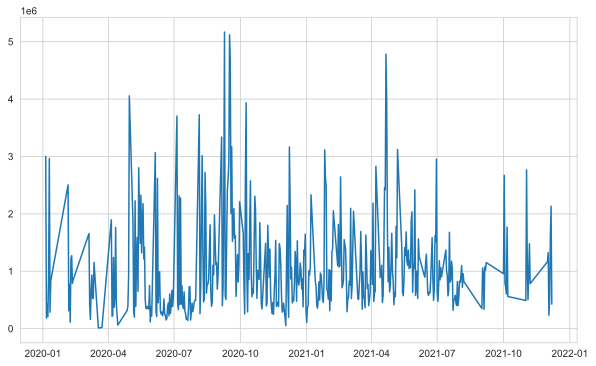

In [19]:
x = data_group['дата_2']
y = data_group['сумма']
plt.plot(x,y)
plt.show()

Построим гистограмму зависимости частоты покупок от количество часов.

In [20]:
data['часы'] = data['дата'].dt.hour
data

,дата,транзакция,клиент,товар,количество,сумма,дата_2,часы
0,2020-03-05 21:43:00,954,1,2874.0,1,8150.0,2020-03-05,21
1,2020-11-20 20:46:00,13796,1,3586.0,1,3930.0,2020-11-20,20
2,2020-08-12 16:28:00,14431,1,4942.0,1,2860.0,2020-08-12,16
3,2020-03-05 21:15:00,951,2,2812.0,1,4895.0,2020-03-05,21
4,2020-05-20 16:46:00,3352,2,5025.0,1,840.0,2020-05-20,16
...,...,...,...,...,...,...,...,...
48298,2021-06-07 15:00:00,25398,11049,1211.0,1,20500.0,2021-06-07,15
48299,2021-06-07 15:13:00,25399,11049,3034.0,1,21950.0,2021-06-07,15
48300,2021-06-07 15:02:00,25412,11050,443.0,1,1490.0,2021-06-07,15
48301,2021-06-07 15:02:00,25412,11050,2789.0,1,9450.0,2021-06-07,15


In [21]:
data_group = data[['количество', 'часы']].groupby('часы').sum().reset_index()
data_group

,часы,количество
0,0,3
1,10,384
2,11,1294
3,12,2484
4,13,3293
5,14,4159
6,15,4665
7,16,5071
8,17,5130
9,18,5033


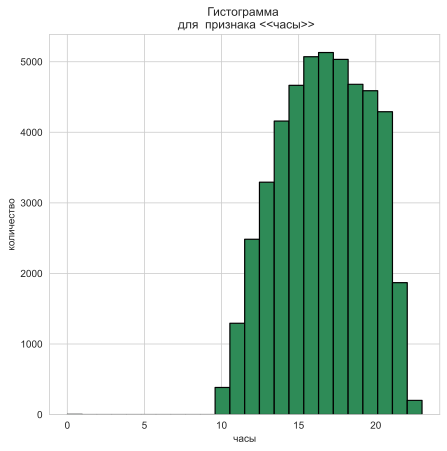

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(7,7))
axes.hist(data['часы'], bins = 24, color = "seagreen", edgecolor='black', linewidth=1.2)
axes.set_title("Гистограмма \n для  признака <<{}>>".format('часы'))
axes.set_xlabel('часы')
axes.set_ylabel('количество');

Построим точечную диаграмму товаров с максимальной выручкой за все время.

In [23]:
data_time = data[['дата_2', 'сумма']].groupby('дата_2').sum().reset_index()
data_time

,дата_2,сумма
0,2020-01-05,2999052.96
1,2020-01-06,184500.00
2,2020-01-07,430400.00
3,2020-01-08,208770.00
4,2020-01-09,926915.00
...,...,...
461,2021-12-03,234379.50
462,2021-12-04,517908.50
463,2021-12-05,1578498.87
464,2021-12-06,2131892.95


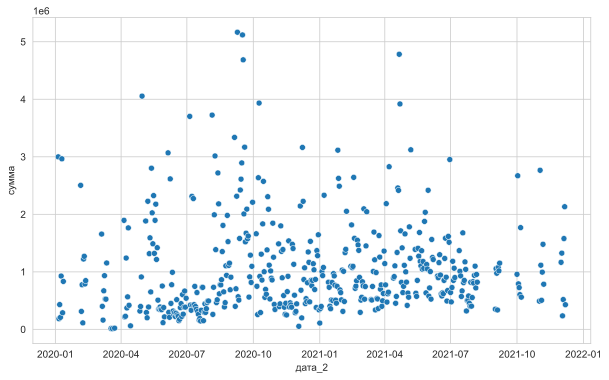

In [24]:
sns.scatterplot(data=data_time, x='дата_2', y='сумма');

Создадим дополнительные признаки: объем продаж и суммарное количество.

In [25]:
data['товар'] = data['товар'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47146 entries, 0 to 48302
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   дата        47146 non-null  datetime64[ns]
 1   транзакция  47146 non-null  int64         
 2   клиент      47146 non-null  int64         
 3   товар       47146 non-null  int32         
 4   количество  47146 non-null  int32         
 5   сумма       47146 non-null  float64       
 6   дата_2      47146 non-null  datetime64[ns]
 7   часы        47146 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int32(2), int64(3)
memory usage: 2.9 MB


In [26]:
data_dop = data[['товар', 'количество', 'сумма']].groupby('товар').sum().reset_index()
data_dop

,товар,количество,сумма
0,1,1,1495.00
1,2,1,14150.00
2,3,1,1200.00
3,4,1,2200.00
4,5,1,4580.89
...,...,...,...
5288,5519,1,5495.00
5289,5520,1,19450.00
5290,5521,1,14950.00
5291,5522,1,24700.00


In [27]:
data_dop['процент_кол'] = data_dop['количество']/data_dop['количество'].sum()*100
data_dop['процент_сум'] = data_dop['сумма']/data_dop['сумма'].sum()*100
data_dop

,товар,количество,сумма,процент_кол,процент_сум
0,1,1,1495.00,0.002121,0.000303
1,2,1,14150.00,0.002121,0.002871
2,3,1,1200.00,0.002121,0.000243
3,4,1,2200.00,0.002121,0.000446
4,5,1,4580.89,0.002121,0.000929
...,...,...,...,...,...
5288,5519,1,5495.00,0.002121,0.001115
5289,5520,1,19450.00,0.002121,0.003946
5290,5521,1,14950.00,0.002121,0.003033
5291,5522,1,24700.00,0.002121,0.005011


**Корреляция**

In [28]:
corr = data_dop.corr()
corr_50 = corr[corr>=.5]
corr_50

,товар,количество,сумма,процент_кол,процент_сум
товар,1.0,NaN,NaN,NaN,NaN
количество,NaN,1.000000,0.733325,1.000000,0.733325
сумма,NaN,0.733325,1.000000,0.733325,1.000000
процент_кол,NaN,1.000000,0.733325,1.000000,0.733325
процент_сум,NaN,0.733325,1.000000,0.733325,1.000000


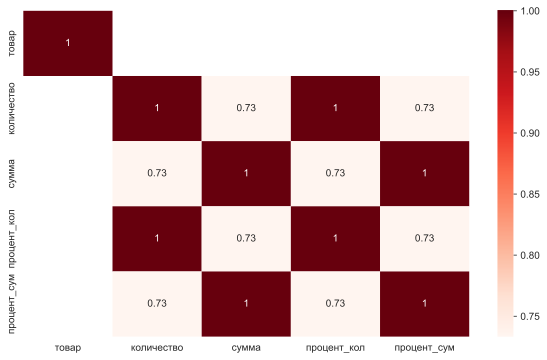

In [29]:
sns.heatmap(corr_50, cmap='Reds', annot=True);

In [30]:
#fig, ax = plt.subplots(figsize=(7,7))
#ax = sns.heatmap(data = data.corr(), annot=True, square=True, 
#           cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(data.corr()))
#plt.title('Матрица корреляций')
#plt.show()

### 5.	Выполнить проверку гипотез о данных

5.1 Зависит ли частота покупок от месяца?

In [31]:
time = data[['дата', 'сумма']]
time.set_index('дата', inplace = True)
time = time.resample('M').sum().sort_values('дата', ascending = True)
time.head()

,сумма
дата,
2020-01-31,8835526.23
2020-02-29,7833534.37
2020-03-31,6075039.39
2020-04-30,12440633.74
2020-05-31,28976122.57


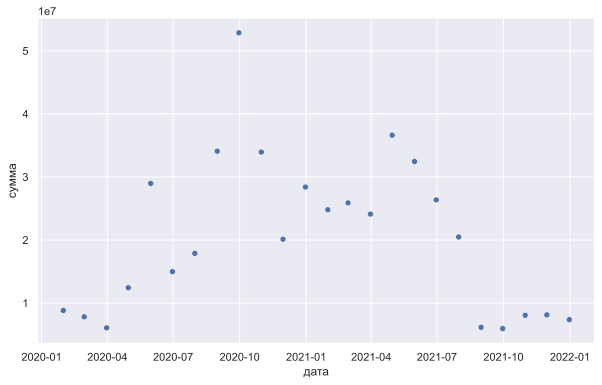

In [32]:
sns.set()
ax = sns.scatterplot(x = 'дата', y = 'сумма', data = time)

 5.2 Больше лучших клиентов, чем потерянных клиентов?
 
 Т.е. выяснить больше ли клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, 
 чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

In [46]:
Now = data['дата_2'].max()
data_client = data.groupby(['транзакция', 'клиент', 'дата_2'])['количество', 'сумма'].sum() \
    .reset_index().drop_duplicates() \
    .groupby('клиент').agg({'дата_2': lambda x: (Now - x.max()).days,
                                           'транзакция': lambda x: len(x),
                                           'сумма': lambda x: x.sum()})
data_client.head()

,дата_2,транзакция,сумма
клиент,,,
1,382,3,14940.0
2,205,4,88540.0
3,642,1,7100.0
4,65,26,351196.5
5,581,1,3035.0


In [58]:
bin_labels = ['1', '2', '3', '4']
bin_labels2 = ['1', '4']

data_client['quantile_затраты'] = pd.qcut(data_client['сумма'],
                                    q=[0, .25, .5, .75, 1],
                                    labels=bin_labels)
data_client['quantile_давность'] = pd.qcut(data_client['дата_2'],
                                    q=[0, .25, .5, .75, 1],
                                    labels=bin_labels)
data_client['quantile_частота'] = pd.qcut(data_client['транзакция'],
                                    q=[.25, .75, 1],
                                    labels=bin_labels2)
data_client['сегменты клиентов'] = data_client['quantile_затраты'].astype(str) + data_client['quantile_давность'].astype(str) \
                                    + data_client['quantile_частота'].astype(str)
data_client

,дата_2,транзакция,сумма,quantile_затраты,quantile_давность,quantile_частота,сегменты клиентов
клиент,,,,,,,
1,382,3,14940.0,2,3,4,234
2,205,4,88540.0,4,2,4,424
3,642,1,7100.0,1,4,1,141
4,65,26,351196.5,4,1,4,414
5,581,1,3035.0,1,4,1,141
...,...,...,...,...,...,...,...
11046,142,2,54580.0,4,1,1,411
11047,122,4,39575.0,3,1,4,314
11048,183,1,17100.0,2,1,1,211


In [48]:
pd.qcut(data_client['сумма'], q=4).value_counts()

(534.999, 7490.0]        2755
(41490.0, 6300874.84]    2747
(17545.0, 41490.0]       2746
(7490.0, 17545.0]        2741
Name: сумма, dtype: int64

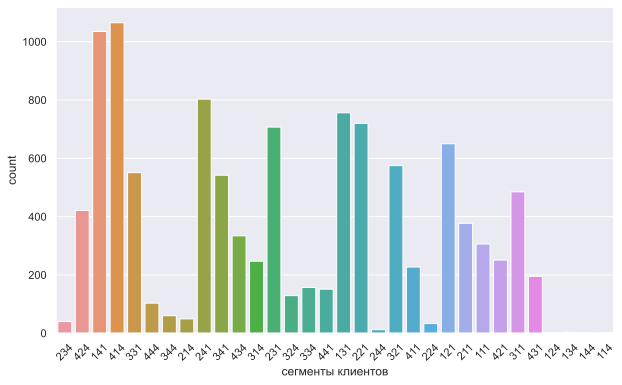

In [51]:
sns.set()
ax = sns.countplot(x = 'сегменты клиентов', data = data_client)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

### 6. Кластеризация по товарам

In [34]:
X = data_dop[['товар', 'количество', 'сумма', 'процент_кол']]
y = data_dop['процент_сум'].values

In [35]:
wcss = []
x = X.to_numpy()

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

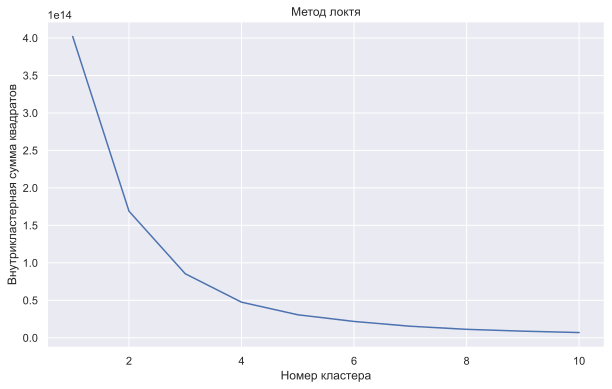

In [36]:
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Номер кластера')
plt.ylabel('Внутрикластерная сумма квадратов') 
plt.show()

In [37]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit(x)
labels1 = kmeans.labels_
centroids1 = kmeans.cluster_centers_
Z = y_kmeans.predict(x)
data_dop['сегмент'] = Z
data_dop

,товар,количество,сумма,процент_кол,процент_сум,сегмент
0,1,1,1495.00,0.002121,0.000303,1
1,2,1,14150.00,0.002121,0.002871,1
2,3,1,1200.00,0.002121,0.000243,1
3,4,1,2200.00,0.002121,0.000446,1
4,5,1,4580.89,0.002121,0.000929,1
...,...,...,...,...,...,...
5288,5519,1,5495.00,0.002121,0.001115,1
5289,5520,1,19450.00,0.002121,0.003946,1
5290,5521,1,14950.00,0.002121,0.003033,1
5291,5522,1,24700.00,0.002121,0.005011,1


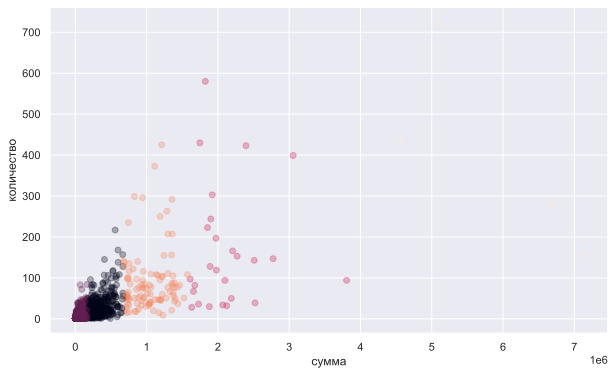

In [38]:
plt.scatter(x = data_dop['сумма'], y = data_dop['количество'], 
            c = data_dop['сегмент'], alpha = 0.3)
plt.xlabel('сумма')
plt.ylabel('количество');

### 7. Важные признаки

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data[['транзакция', 'клиент', 'товар', 'количество']]
y = data.iloc[:, -1]

bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(10, 'Score'))

        Specs         Score
0  транзакция  4.066064e+05
1      клиент  2.574604e+05
2       товар  5.184308e+04
3  количество  4.080698e-23


### 8.	Рекомендации

In [41]:
data_rec = data[['товар', 'клиент', 'количество']].groupby(['товар', 'клиент']).sum().sort_values('количество', ascending = False).reset_index()
data_rec

,товар,клиент,количество
0,2602,4997,21
1,5302,22,19
2,2519,1572,14
3,5305,1323,14
4,5305,3397,13
...,...,...,...
41365,2523,6621,1
41366,2523,6780,1
41367,2523,6967,1
41368,2523,7172,1


In [42]:
data_rec['клиент'] = data_rec['клиент'].astype(str)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
vectorized_data = tfidf.fit_transform(data_rec['клиент'].values)
vectorized_data

<41370x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 33920 stored elements in Compressed Sparse Row format>

In [44]:
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=data_rec['клиент'].index.tolist())

MemoryError: Unable to allocate 1.54 GiB for an array with shape (41370, 5000) and data type float64

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3000)
reduced_data = svd.fit_transform(vectorized_dataframe)
reduced_data.shape

In [ ]:
svd.explained_variance_ratio_.cumsum()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(reduced_data)

In [ ]:
def recommendation(movie_title):
    id_of_movie = df[df['title']==movie_title].index[0]
    distances = similarity[id_of_movie]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:10]
    
    for i in movie_list:
        print(df.iloc[i[0]].title)

In [ ]:
recommendation('The Matrix')

## Вывод